# Model Evaluation and Refinement


## Objectives

*   Evaluate and refine prediction models

<h2>Table of Contents</h2>
<ul>
    <li><a href="#Part-1:-Training-and-Testing">Splitting Data</a></li>
    <li><a href="#Part-2:-Model-Selection,-Overfitting-and-Underfitting">Model Selection, Over-fitting and Under-fitting</a></li>
    <li><a href="#Part-3:-Ridge-Regression">Ridge Regression </a></li>
    <li><a href="#Part-4:-Grid-Search">Grid Search</a></li>
</ul>


In [66]:
import pandas as pd
import numpy as np
# For plotting
#from ipywidgets import interact, interactive, fixed, interact_manual
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [67]:
df = pd.read_csv("clean_auto_df.csv")
pd.set_option('display.max_columns',None)

# Converting highway-L/100km back to highway-mpg

df['highway-L/100km'] = 235/df["highway-L/100km"]

# renaming column name from "highway-mpg" to "highway-L/100km"
df.rename(columns={'highway-L/100km':'highway-mpg'}, inplace=True)

# checking transformed data 
df.head()

,symboling,normalized-losses,make,num-of-doors,body-style,drive-wheels,engine-location,wheel-base,length,width,height,curb-weight,engine-type,num-of-cylinders,engine-size,fuel-system,bore,stroke,compression-ratio,horsepower,peak-rpm,city-mpg,highway-mpg,price,city-L/100km,horsepower-binned,fuel-type-diesel,fuel-type-gas,aspiration-std,aspiration-turbo
0,3,122,alfa-romero,two,convertible,rwd,front,88.6,0.811148,0.890278,0.816054,2548,dohc,four,130,mpfi,3.47,2.68,9.0,111,5000.0,21,27.0,13495.0,11.190476,Low,0,1,1,0
1,3,122,alfa-romero,two,convertible,rwd,front,88.6,0.811148,0.890278,0.816054,2548,dohc,four,130,mpfi,3.47,2.68,9.0,111,5000.0,21,27.0,16500.0,11.190476,Low,0,1,1,0
2,1,122,alfa-romero,two,hatchback,rwd,front,94.5,0.822681,0.909722,0.876254,2823,ohcv,six,152,mpfi,2.68,3.47,9.0,154,5000.0,19,26.0,16500.0,12.368421,Medium,0,1,1,0
3,2,164,audi,four,sedan,fwd,front,99.8,0.848630,0.919444,0.908027,2337,ohc,four,109,mpfi,3.19,3.40,10.0,102,5500.0,24,30.0,13950.0,9.791667,Low,0,1,1,0
4,2,164,audi,four,sedan,4wd,front,99.4,0.848630,0.922222,0.908027,2824,ohc,five,136,mpfi,3.19,3.40,8.0,115,5500.0,18,22.0,17450.0,13.055556,Low,0,1,1,0


In [68]:
df.shape

(201, 30)

First, let's only use numeric data:


In [69]:
df=df._get_numeric_data()
df.head()

,symboling,normalized-losses,wheel-base,length,width,height,curb-weight,engine-size,bore,stroke,compression-ratio,horsepower,peak-rpm,city-mpg,highway-mpg,price,city-L/100km,fuel-type-diesel,fuel-type-gas,aspiration-std,aspiration-turbo
0,3,122,88.6,0.811148,0.890278,0.816054,2548,130,3.47,2.68,9.0,111,5000.0,21,27.0,13495.0,11.190476,0,1,1,0
1,3,122,88.6,0.811148,0.890278,0.816054,2548,130,3.47,2.68,9.0,111,5000.0,21,27.0,16500.0,11.190476,0,1,1,0
2,1,122,94.5,0.822681,0.909722,0.876254,2823,152,2.68,3.47,9.0,154,5000.0,19,26.0,16500.0,12.368421,0,1,1,0
3,2,164,99.8,0.848630,0.919444,0.908027,2337,109,3.19,3.40,10.0,102,5500.0,24,30.0,13950.0,9.791667,0,1,1,0
4,2,164,99.4,0.848630,0.922222,0.908027,2824,136,3.19,3.40,8.0,115,5500.0,18,22.0,17450.0,13.055556,0,1,1,0


<h2>Functions for Plotting</h2>


In [70]:
def DistributionPlot(RedFunction, BlueFunction, RedName, BlueName, Title):

    ax1 = sns.distplot(RedFunction, hist=False, color="r", label=RedName)
    ax2 = sns.distplot(BlueFunction, hist=False, color="b", label=BlueName, ax=ax1)

    plt.title(Title)
    plt.xlabel('Price (in dollars)')
    plt.ylabel('Proportion of Cars')

    plt.show()
    plt.close()

In [71]:
def PollyPlot(xtrain, xtest, y_train, y_test, lr,poly_transform):
    
    
    #training data 
    #testing data 
    # lr:  linear regression object 
    #poly_transform:  polynomial transformation object 
 
    xmax=max([xtrain.values.max(), xtest.values.max()])

    xmin=min([xtrain.values.min(), xtest.values.min()])

    x=np.arange(xmin, xmax, 0.1)


    plt.plot(xtrain, y_train, 'ro', label='Training Data')
    plt.plot(xtest, y_test, 'go', label='Test Data')
    plt.plot(x, lr.predict(poly_transform.fit_transform(x.reshape(-1, 1))), label='Predicted Function')
    plt.ylim([-10000, 60000])
    plt.ylabel('Price')
    plt.legend()

<h2 id="ref1">Part 1: Training and Testing</h2>

<p>When splitting data into training and testing sets in Python, the optimal ratio depends on the size of your dataset and the nature of the problem you're trying to solve. However, some commonly used ratios are:

70:30 (70% training, 30% testing)
    
80:20 (80% training, 20% testing)
    
75:25 (75% training, 25% testing)
    
Generally, you'll want to allocate a larger portion of the data for training to ensure that the model can learn effectively from a representative sample. However, it's also important to reserve a sufficient amount of data for testing to assess the model's performance on unseen data accurately.

If your dataset is large, you may be able to allocate a smaller percentage to the testing set, as even a smaller percentage would still provide a significant number of samples for evaluation. In contrast, for smaller datasets, you might want to allocate a larger percentage to the testing set to ensure that the evaluation is reliable.</p>

<p>An important step in testing your model is to split your data into training and testing data. We will place the target data <b>price</b> in a separate dataframe <b>y_data</b>:</p>


In [72]:
y_data = df['price']

Drop price data in dataframe **x_data**:


In [73]:
x_data=df.drop('price',axis=1)

Now, we randomly split our data into training and testing data using the function <b>train_test_split</b>.


In [74]:
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.2, random_state=0)

print("number of test samples :", x_test.shape[0])
print("number of training samples:",x_train.shape[0])


number of test samples : 41
number of training samples: 160


In [75]:
lm = LinearRegression() 
lm.fit(x_train[['horsepower']], y_train)

lm.score(x_train[['horsepower']], y_train)

0.6090914109586216

In [76]:
lm.score(x_test[['horsepower']], y_test)

0.7827671583537403

We can see the $R^2$ is smaller using the trainig data compared to the testing data.


The <b>test_size</b> parameter sets the proportion of data that is split into the testing set. In the above, the testing set is 30% of the total dataset.


<h3>Next, we use the function "train_test_split" to split up the dataset such that 40% of the data samples will be utilized for testing. We set the parameter "random_state" equal to zero. </h3>

In [77]:
x_train1, x_test1, y_train1, y_test1 = train_test_split(x_data, y_data, test_size=0.4, random_state=0) 
print("number of test samples :", x_test1.shape[0])
print("number of training samples:",x_train1.shape[0])

number of test samples : 81
number of training samples: 120


We create a Linear Regression object:


In [78]:
lm = LinearRegression() 

We fit the model using the feature "horsepower":


In [79]:
lm.fit(x_train1[['horsepower']], y_train1)

LinearRegression()

Let's calculate the $R^2$ on the training data:


In [80]:
lm.score(x_train1[['horsepower']], y_train1)

0.5754853866574969

Let's calculate the $R^2$ on the training data:


In [81]:
lm.score(x_test1[['horsepower']], y_test1)

0.7139737368233015

We can see the $R^2$ is smaller using the training data compared to the test data.


Sometimes we do not have sufficient testing data and we may want to know what the optimal testing size is; as a result, we may want to perform cross-validation. Let's go over several methods that you can use for cross-validation.


<h2>Cross-Validation Score</h2>


<p>A better approach to determine the optimal test size is to use cross-validation. K-fold cross-validation allows you to evaluate the model's performance more reliably by training and testing it on different subsets of the data.</p>

We input the object, the feature ("horsepower"), and the target data (y_data). The parameter 'cv' determines the number of folds. In this case, it is 4.


In [82]:
Rcross = cross_val_score(lm, x_data[['horsepower']], y_data, cv=4)

The default scoring is $R^2$. Each element in the array has the average $R^2$ value for the fold:


In [83]:
Rcross

array([0.77465419, 0.51718424, 0.74814454, 0.04825398])

We can calculate the average and standard deviation of our estimate:


In [84]:
print("The mean of the folds are", Rcross.mean(), "and the standard deviation is" , Rcross.std())

The mean of the folds are 0.5220592359225414 and the standard deviation is 0.29130480666118436


We can use negative squared error as a score by setting the parameter  'scoring' metric to 'neg_mean_squared_error'.


In [85]:
-1 * cross_val_score(lm,x_data[['horsepower']], y_data,cv=4,scoring='neg_mean_squared_error')

array([20251357.7835463 , 43743920.05390439, 12525158.34507633,
       17564549.69976653])

<h3> Calculating the average $R^2$ using two folds, then finding the average $R^2$ for the second fold utilizing the "horsepower" feature: </h3>


In [86]:
Rc=cross_val_score(lm,x_data[['horsepower']], y_data,cv=2)
Rc.mean()

0.516835099979672

We can also use the function 'cross_val_predict' to predict the output. The function splits up the data into the specified number of folds, with one fold for testing and the other folds are used for training.

We input the object, the feature <b>"horsepower"</b>, and the target data <b>y_data</b>. The parameter 'cv' determines the number of folds. In this case, it is 4. We can produce an output:


In [87]:
yhat = cross_val_predict(lm,x_data[['horsepower']], y_data,cv=2)
yhat[0:5]

array([13578.49918955, 13578.49918955, 19355.18720413, 12369.42495394,
       14115.86551648])

Using cross validation, we can see that the 4 folds performs slighty better, in other words using about 25% of the data for testing performs slightly better when modeling a linear regression model with <code>'horsepower'</code>.

<h2 id="ref2">Part 2: Model Selection, Overfitting and Underfitting</h2>

<p>It turns out that the test data, sometimes referred to as the "out of sample data", is a much better measure of how well your model performs in the real world.  One reason for this is overfitting.

We will go over some examples. It turns out these differences are more apparent in Multiple Linear Regression and Polynomial Regression so we will explore overfitting in that context.</p>

<h4>Model Selection</h4>

Let's create Multiple Linear Regression objects and train the model using <b>'horsepower'</b>, <b>'curb-weight'</b>, <b>'engine-size'</b> and <b>'highway-mpg'</b> as features.


In [88]:
# Using 20% for testing
lr = LinearRegression()
lr.fit(x_train[['horsepower', 'curb-weight', 'engine-size', 'highway-mpg']], y_train)

LinearRegression()

Prediction using training data:


In [89]:
yhat_train = lr.predict(x_train[['horsepower', 'curb-weight', 'engine-size', 'highway-mpg']])
yhat_train[0:5]

array([23900.96319876,  8508.62022934, 19173.38530171, 17482.07876063,
       13823.41951664])

Prediction using test data:


In [90]:
yhat_test = lr.predict(x_test[['horsepower', 'curb-weight', 'engine-size', 'highway-mpg']])
yhat_test[0:5]

array([ 5108.26776617, 10616.03148053, 20362.16991455, 21969.63017939,
       20674.92991986])

In [91]:
lr.score(x_train[['horsepower', 'curb-weight', 'engine-size', 'highway-mpg']], y_train)

0.8103353272636677

In [92]:
lr.score(x_test[['horsepower', 'curb-weight', 'engine-size', 'highway-mpg']], y_test)

0.7693888374717845

# Let's perform some model evaluation using our training and testing data separately. 

Let's examine the distribution of the predicted values of the training data.


C:\Users\omarg\AppData\Local\Temp\ipykernel_2440\1129970094.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  ax1 = sns.distplot(RedFunction, hist=False, color="r", label=RedName)
C:\Users\omarg\AppData\Local\Temp\ipykernel_2440\1129970094.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  ax2 = sns.

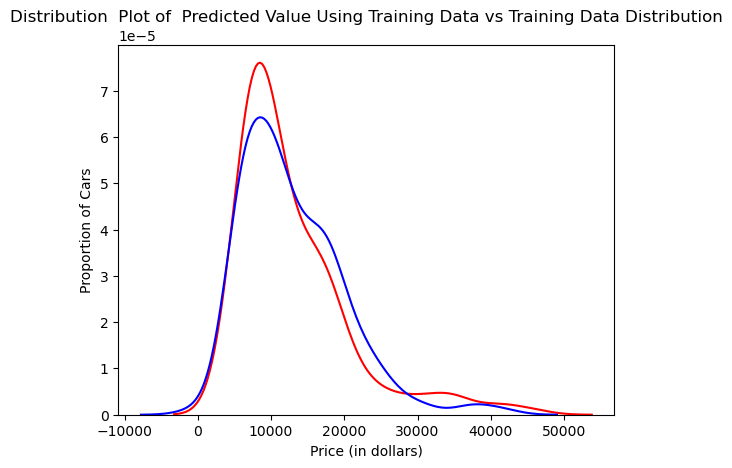

In [93]:
Title = 'Distribution  Plot of  Predicted Value Using Training Data vs Training Data Distribution'
DistributionPlot(y_train, yhat_train, "Actual Values (Train)", "Predicted Values (Train)", Title)

Figure 1: Plot of predicted values using the training data compared to the actual values of the training data.


So far, the model seems to be doing well in learning from the training dataset. But what happens when the model encounters new data from the testing dataset? When the model generates new values from the test data, we see the distribution of the predicted values is much different from the actual target values.


C:\Users\omarg\AppData\Local\Temp\ipykernel_2440\1129970094.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  ax1 = sns.distplot(RedFunction, hist=False, color="r", label=RedName)
C:\Users\omarg\AppData\Local\Temp\ipykernel_2440\1129970094.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  ax2 = sns.

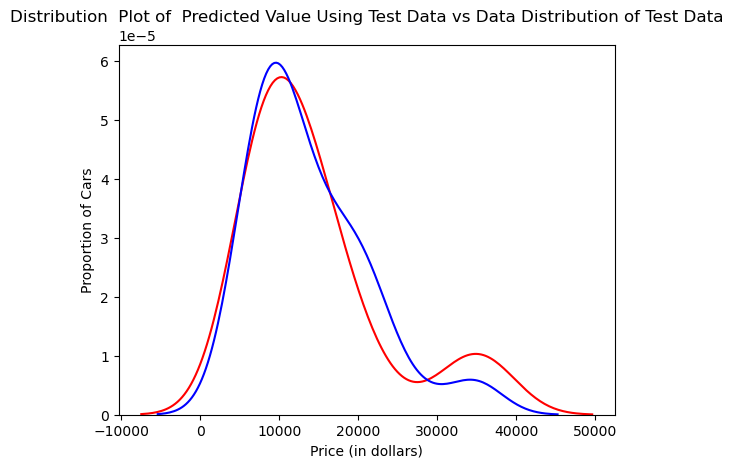

In [94]:
Title='Distribution  Plot of  Predicted Value Using Test Data vs Data Distribution of Test Data'
DistributionPlot(y_test,yhat_test,"Actual Values (Test)","Predicted Values (Test)",Title)

Figure 2: Plot of predicted value using the test data compared to the actual values of the test data.


<p>Comparing Figure 1 and Figure 2, we can see that the distribution of the testing data in Figure 1 is much better at fitting the data. This difference in Figure 1 is apparent in the range of 15000 to 30,000. This is where the shape of the distribution is extremely different. Let's see if polynomial regression also exhibits a drop in the prediction accuracy when analysing the test dataset.</p>


<h4>Overfitting</h4>
<p>Overfitting occurs when the model fits the noise, but not the underlying process. Therefore, when testing your model using the test set, your model does not perform as well since it is modelling noise, not the underlying process that generated the relationship. Let's create a degree 5 polynomial model.</p>


Let's use the initial data split where we use 20% of the data for training:


We will perform a degree 5 polynomial transformation on the feature <b>'horsepower'</b>.


In [95]:
x_train2, x_test2, y_train2, y_test2 = train_test_split(x_data, y_data, test_size=0.55, random_state=5)


In [96]:
pr = PolynomialFeatures(degree=5)
x_train_pr = pr.fit_transform(x_train2[['horsepower']])
x_test_pr = pr.fit_transform(x_test2[['horsepower']])
pr

PolynomialFeatures(degree=5)

Now, let's create a Linear Regression model "poly" and train it.


In [97]:
poly = LinearRegression()
poly.fit(x_train_pr, y_train2)

LinearRegression()

We can see the output of our model using the method "predict." We assign the values to "yhat".


In [98]:
yhat = poly.predict(x_test_pr)
yhat[0:5]

array([ 6346.25971593, 15631.37990325,  6439.67731375,  6439.67731375,
       15454.8469419 ])

Let's take the first five predicted values and compare it to the actual targets.


In [99]:
print("Predicted values:", yhat[0:4])
print("True values:", y_test2[0:4].values)

Predicted values: [ 6346.25971593 15631.37990325  6439.67731375  6439.67731375]
True values: [7609. 9959. 6918. 7898.]


We will use the function "PollyPlot" that we defined at the beginning of the lab to display the training data, testing data, and the predicted function.


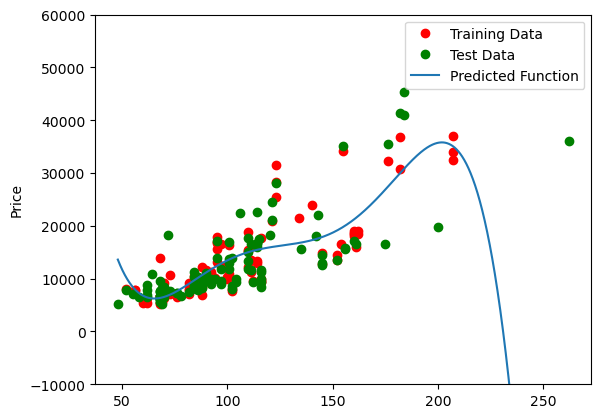

In [100]:
PollyPlot(x_train2[['horsepower']], x_test2[['horsepower']], y_train2, y_test2, poly,pr)

Figure 3: A polynomial regression model where red dots represent training data, green dots represent test data, and the blue line represents the model prediction.


We see that the estimated function appears to track the data but around 200-250 horsepower, the function begins to diverge from the data points.


$R^2$ of the training data:


In [101]:
poly.score(x_train_pr, y_train2)

0.7187587765209544

$R^2$ of the test data:


In [102]:
poly.score(x_test_pr, y_test2)

-9.316253256298037

We see the $R^2$ for the training data is 0.7188 while the $R^2$ on the test data was -9.32.  The lower the $R^2$, the worse the model. <b>A negative $R^2$ is a sign of overfitting.</b>


Let's see how the $R^2$ changes on the test data for different order polynomials and then plot the results:


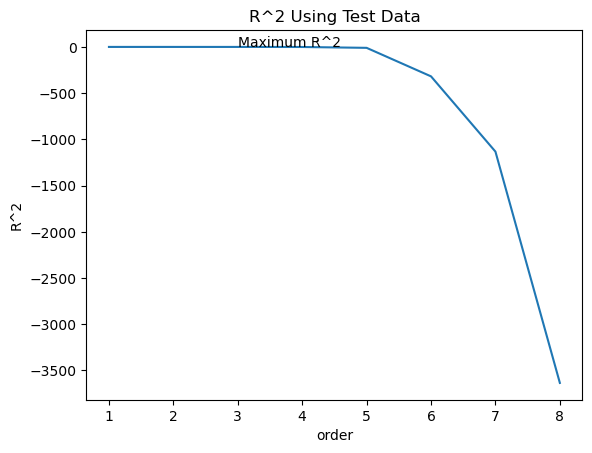

In [103]:
Rsqu_test = []

order = [1, 2, 3, 4,5,6,7,8]
for n in order:
    pr = PolynomialFeatures(degree=n)
    
    x_train_pr = pr.fit_transform(x_train2[['horsepower']])
    
    x_test_pr = pr.fit_transform(x_test2[['horsepower']])    
    
    lr.fit(x_train_pr, y_train2)
    
    Rsqu_test.append(lr.score(x_test_pr, y_test2))

plt.plot(order, Rsqu_test)
plt.xlabel('order')
plt.ylabel('R^2')
plt.title('R^2 Using Test Data')
plt.text(3, 0.75, 'Maximum R^2 ')    
plt.show()

We see the $R^2$ is around 0 until an order 5 polynomial is used. Then, the $R^2$ dramatically decreases at an order 5 polynomial.


## Let us now look at a polynomial transformation of the model we created at the beginning of part 2

In [104]:
Input=[('polynomial', PolynomialFeatures(degree=2, include_bias=False)),('model',LinearRegression())]

pipe = Pipeline(Input)
pipe.fit(x_train[['horsepower', 'curb-weight', 'engine-size', 'highway-mpg']],y_train)

Pipeline(steps=[('polynomial', PolynomialFeatures(include_bias=False)),
                ('model', LinearRegression())])

In [105]:
pipe.score(x_train[['horsepower', 'curb-weight', 'engine-size', 'highway-mpg']],y_train)

0.860039914345144

In [106]:
pipe.score(x_test[['horsepower', 'curb-weight', 'engine-size', 'highway-mpg']],y_test)

0.7434402394526768

This model performs slightly worse than the model without a polynomila transormation

<!-- The answer is below:

x_train_pr1=pr.fit_transform(x_train[['horsepower', 'curb-weight', 'engine-size', 'highway-mpg']])
x_test_pr1=pr.fit_transform(x_test[['horsepower', 'curb-weight', 'engine-size', 'highway-mpg']])

-->


## Let us see what the distribution plots look like now

C:\Users\omarg\AppData\Local\Temp\ipykernel_2440\1129970094.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  ax1 = sns.distplot(RedFunction, hist=False, color="r", label=RedName)
C:\Users\omarg\AppData\Local\Temp\ipykernel_2440\1129970094.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  ax2 = sns.

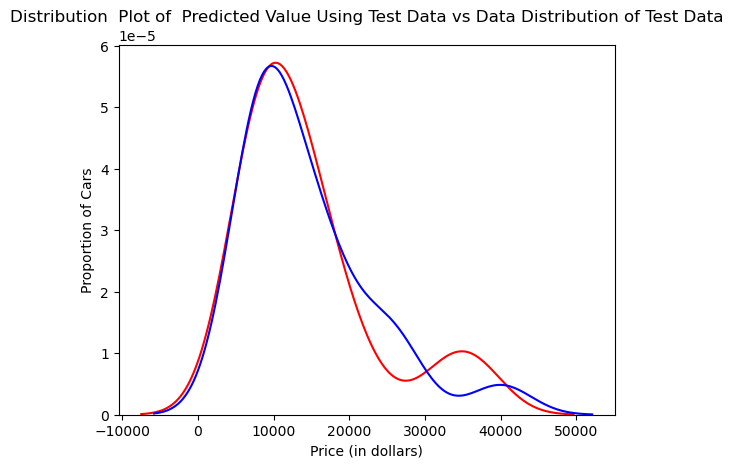

In [107]:
yhat_test1=pipe.predict(x_test[['horsepower', 'curb-weight', 'engine-size', 'highway-mpg']])

Title='Distribution  Plot of  Predicted Value Using Test Data vs Data Distribution of Test Data'

DistributionPlot(y_test, yhat_test1, "Actual Values (Test)", "Predicted Values (Test)", Title)

The model performs almost perfect all the way up to about 10,000. Then we see that the model under-performs from 20,000 - 40,000

We can see this below

In [108]:
print("predicted values:",yhat_test1[0:4])
print("True values:",y_test[0:4].values)

predicted values: [ 6311.60781719 10256.45472356 24996.60931736 21134.26379903]
True values: [ 6295. 10698. 13860. 13499.]


<h2 id="ref3">Part 3: Ridge Regression</h2> 


In this section, we will review Ridge Regression and see how the parameter alpha changes the model. Just a note, here our test data will be used as validation data.

We will use the polynomial model of degree 2 that we just created

Let's create a Ridge regression object, setting the regularization parameter (alpha) to 0.1 and then fit the model


In [109]:
Input=[('polynomial', PolynomialFeatures(degree=2, include_bias=False)),('ridge', Ridge(alpha=.1))]

pipe = Pipeline(Input)
pipe.fit(x_train[['horsepower', 'curb-weight', 'engine-size', 'highway-mpg']],y_train)

Pipeline(steps=[('polynomial', PolynomialFeatures(include_bias=False)),
                ('ridge', Ridge(alpha=0.1))])

Similar to linear regression, we can obtain a prediction:


In [110]:
pipe.score(x_test[['horsepower', 'curb-weight', 'engine-size', 'highway-mpg']],y_test)

0.7438457579993738

This model is still not as good as the model without polynomial transformation

In [111]:
yhat = pipe.predict(x_test[['horsepower', 'curb-weight', 'engine-size', 'highway-mpg']])

Let's compare the first five predicted samples to our test set:


In [112]:
print('predicted:', yhat[0:4])
print('test set :', y_test[0:4].values)

predicted: [ 6304.11220502 10245.04609706 24973.7385805  21128.39556421]
test set : [ 6295. 10698. 13860. 13499.]


We select the value of alpha that minimizes the test error. To do so, we can use a for loop. We have also created a progress bar to see how many iterations we have completed so far.


In [113]:
from tqdm import tqdm

Rsqu_test = []
Rsqu_train = []
dummy1 = []
Alpha = 10 * np.array(range(0,1000))
pbar = tqdm(Alpha)

for alpha in pbar:
    Input=[('polynomial', PolynomialFeatures(degree=2, include_bias=False)),('ridge', Ridge(alpha=alpha))]
    pipe = Pipeline(Input)
    pipe.fit(x_train[['horsepower', 'curb-weight', 'engine-size', 'highway-mpg']],y_train)
    
    test_score, train_score = pipe.score(x_test[['horsepower', 'curb-weight', 'engine-size', 'highway-mpg']], y_test), \
                            pipe.score(x_train[['horsepower', 'curb-weight', 'engine-size', 'highway-mpg']], y_train)
    
    pbar.set_postfix({"Test Score": test_score, "Train Score": train_score})

    Rsqu_test.append(test_score)
    Rsqu_train.append(train_score)

100%|██████████| 1000/1000 [00:15<00:00, 62.65it/s, Test Score=0.751, Train Score=0.857]


We can plot out the value of $R^2$ for different alphas:


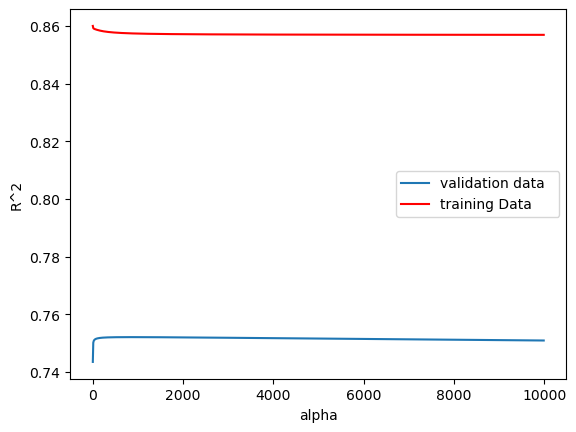

In [114]:
plt.plot(Alpha,Rsqu_test, label='validation data  ')
plt.plot(Alpha,Rsqu_train, 'r', label='training Data ')
plt.xlabel('alpha')
plt.ylabel('R^2')
plt.legend()

**Figure 4**: The blue line represents the $R^2$ of the validation data, and the red line represents the $R^2$ of the training data. The x-axis represents the different values of Alpha.


Here the model is built and tested on the same data, so the training and test data are the same.

The red line in Figure 4 represents the $R^2$ of the training data. As alpha increases the $R^2$ decreases. Therefore, as alpha increases, the model performs worse on the training data

The blue line represents the $R^2$ on the validation data. As the value for alpha increases, the $R^2$ increases and converges at a point.


#### We now perform ridge regression. We calculate the $R^2$ using the polynomial features, use the training data to train the model and use the test data to test the model with the parameter alpha set to 10.

In [115]:
Input=[('polynomial', PolynomialFeatures(degree=2, include_bias=False)),('ridge', Ridge(alpha=10))]

pipe = Pipeline(Input)
pipe.fit(x_train[['horsepower', 'curb-weight', 'engine-size', 'highway-mpg']],y_train)
pipe.score(x_test[['horsepower', 'curb-weight', 'engine-size', 'highway-mpg']],y_test)


0.7500941122459532

This is an improvement but we have a slightly higher $R^2$ with the model with no polynomial tranformation

<h2 id="ref4">Part 4: Grid Search</h2>


The term alpha is a hyperparameter. Sklearn has the class <b>GridSearchCV</b> to make the process of finding the best hyperparameter simpler.

#### Grid search for alpha on model with no polynomial transformation

We create a dictionary of parameter values:


In [136]:
parameters1= [{'alpha': [0.001,0.1,1, 10, 100, 1000, 10000, 100000, 100000]}]
parameters1

[{'alpha': [0.001, 0.1, 1, 10, 100, 1000, 10000, 100000, 100000]}]

Create a Ridge regression object:


In [137]:
RR=Ridge()
RR

Ridge()

Create a ridge grid search object:


In [138]:
Grid1 = GridSearchCV(RR, parameters1,cv=4)


Fit the model:


In [139]:
Grid1.fit(x_train[['horsepower', 'curb-weight', 'engine-size', 'highway-mpg']], y_train)

GridSearchCV(cv=4, estimator=Ridge(),
             param_grid=[{'alpha': [0.001, 0.1, 1, 10, 100, 1000, 10000, 100000,
                                    100000]}])

The object finds the best parameter values on the validation data. We can obtain the estimator with the best parameters and assign it to the variable BestRR as follows:


In [140]:
BestRR=Grid1.best_estimator_
BestRR

Ridge(alpha=10000)

We now test our model on the test data:


In [141]:
BestRR.score(x_test[['horsepower', 'curb-weight', 'engine-size', 'highway-mpg']], y_test)

0.7636729391076946

This is a good model as it performs almost as good as the model with no transformations

#### Now, Grid search for alpha on model with polynomial transformation

In [145]:
# Create a pipeline with polynomial feature transformation and Ridge regression
pipe = Pipeline([
    ('poly', PolynomialFeatures()),
    ('ridge', Ridge())
])

# Specify the hyperparameter search space, including both the polynomial degree and Ridge alpha
param_grid = {
    'poly__degree': [2, 3, 4],
    'ridge__alpha': [0.001, 0.01, 0.1, 1, 10, 100]
}

# Perform grid search with 4-fold cross-validation
grid_search = GridSearchCV(pipe, param_grid, cv=4)

# Fit the GridSearchCV object on the entire dataset (raw data)
grid_search.fit(x_train[['horsepower', 'curb-weight', 'engine-size', 'highway-mpg']], y_train)


C:\Users\omarg\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=9.32302e-19): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\omarg\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=1.04186e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\omarg\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=9.25598e-19): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\omarg\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=1.00246e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\omarg\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:21

GridSearchCV(cv=4,
             estimator=Pipeline(steps=[('poly', PolynomialFeatures()),
                                       ('ridge', Ridge())]),
             param_grid={'poly__degree': [2, 3, 4],
                         'ridge__alpha': [0.001, 0.01, 0.1, 1, 10, 100]})

In [146]:
BestRR=grid_search.best_estimator_
BestRR

Pipeline(steps=[('poly', PolynomialFeatures()), ('ridge', Ridge(alpha=100))])

In [147]:
BestRR.score(x_test[['horsepower', 'curb-weight', 'engine-size', 'highway-mpg']], y_test)

0.7516044748204138

Using GridSearch, we see that the best hyperparameter are degree = 2 and alpha = 100

The model with just a ridge regression performs slightly better than this model


#### Let us now see what the distribution plot looks like for these hyperparameters

C:\Users\omarg\AppData\Local\Temp\ipykernel_2440\1129970094.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  ax1 = sns.distplot(RedFunction, hist=False, color="r", label=RedName)
C:\Users\omarg\AppData\Local\Temp\ipykernel_2440\1129970094.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  ax2 = sns.

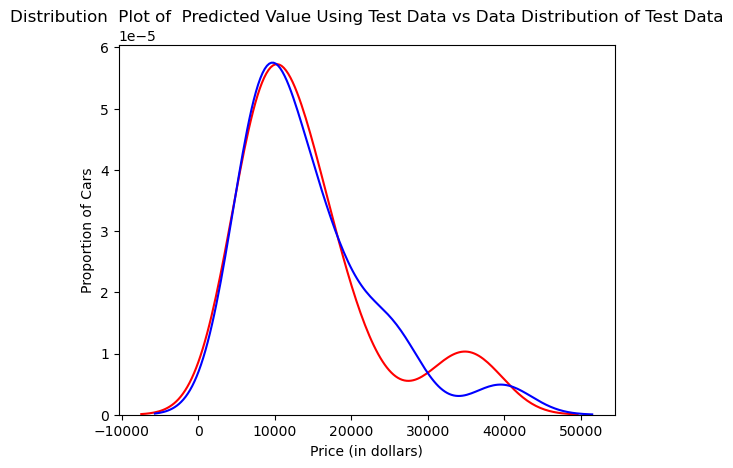

In [155]:
yhat_test2=BestRR.predict(x_test[['horsepower', 'curb-weight', 'engine-size', 'highway-mpg']])

Title='Distribution  Plot of  Predicted Value Using Test Data vs Data Distribution of Test Data'

DistributionPlot(y_test, yhat_test2, "Actual Values (Test)", "Predicted Values (Test)", Title)

# Conclusion :

After looking at several models with and without transformations we can say that the Multpile Linear Regression model is the best  model as it does a pretty good job of predicting the actual price. The only area where it lacks is from 20,000 to 40,000 but not as much as other models. The model with the best hyperparameters seems to perform better at the beginning range but then does a worse job then other models from 20,000 to 40,000

Below I perform Cross Validation to back up these claims

In [157]:
pr1 = Pipeline([
    ('poly', PolynomialFeatures()),
    ('linear', LinearRegression())
])

# Creating a polynomial model with Ridge regression
polynomial_ridge_model = Pipeline([
    ('poly', PolynomialFeatures()),
    ('ridge', Ridge(alpha=100))  
])


In [158]:
# Performing cross-validation on both models and calculating their respective performance metrics (e.g., R-squared)
linear_scores = cross_val_score(lm, x_train[['horsepower', 'curb-weight', 'engine-size', 'highway-mpg']], y_train, cv=4, scoring='r2')
polynomial_scores = cross_val_score(pr1, x_train[['horsepower', 'curb-weight', 'engine-size', 'highway-mpg']], y_train, cv=4, scoring='r2')
polynomial_ridge_scores = cross_val_score(polynomial_ridge_model, x_train[['horsepower', 'curb-weight', 'engine-size', 'highway-mpg']], y_train, cv=4, scoring='r2')


# Calculating the average R-squared scores for all models
linear_avg_score = np.mean(linear_scores)
polynomial_avg_score = np.mean(polynomial_scores)
polynomial_ridge_avg_score = np.mean(polynomial_ridge_scores)

print("Linear model average R-squared score:", linear_avg_score)
print("Polynomial model average R-squared score:", polynomial_avg_score)
print("Polynomial model with Ridge regression average R-squared score:", polynomial_ridge_avg_score)


# Comparing the performance metrics of all models
best_model = np.argmax([linear_avg_score, polynomial_avg_score, polynomial_ridge_avg_score])
model_names = ["Linear model", "Polynomial model", "Polynomial model with Ridge regression"]
print("Best performing model:", model_names[best_model])

Linear model average R-squared score: 0.7726354659852721
Polynomial model average R-squared score: 0.7510042656051966
Polynomial model with Ridge regression average R-squared score: 0.758903161834022
Best performing model: Linear model
